<a href="https://colab.research.google.com/github/Meysam-shirdel/GPT/blob/main/GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT 2

## Install & Import Libraries

In [ ]:
!pip  install -q tiktoken
!pip install -q tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
import math
import os
import warnings
import time
import random


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from   torch.utils.data import Dataset, DataLoader
from   torch.nn import functional as F
import torch.utils.checkpoint
from   torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from dataclasses import dataclass
from typing import Optional, Tuple, Union


from transformers import GPT2LMHeadModel

import tiktoken
import tqdm


## Config

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device ='cuda'
#---------------------------------GPTConfig -----------------------------
@dataclass
class GPTConfig:
  n_layers: int= 12
  n_heads: int = 12
  n_embed: int = 768
  vocab_size: int= 50257
  block_size: int= 32



In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Load Dataset

In [ ]:
!wget -q https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

###  DataSet

In [ ]:
def create_vocabs(file_path):

    with open(file_path, 'r') as f:
      text = f.read()
    encoder = tiktoken.get_encoding("gpt2")
    tokens = torch.tensor(encoder.encode(text))
    tr_tokens = tokens[: int(len(tokens)*0.8)]
    val_tokens = tokens[int(len(tokens)*0.8) :]

    return tr_tokens, val_tokens

train_tokens, valid_tokens = create_vocabs('input.txt')

In [ ]:
class Custom_Dataset(Dataset):
  def __init__(self, tokens, block_size ):

    self.block_size = block_size   # length of token sequesnce
    self.tokens = tokens
    r = len(self.tokens) % block_size
    self.tokens = self.tokens[:-r].view(-1, block_size)


  def __getitem__(self, idx):
    temp = self.tokens[idx]
    x = temp[:-1]
    y = temp[1:]

    return x,y

  def __len__(self):
    return self.tokens.shape[0]

In [ ]:
train_set = Custom_Dataset(train_tokens, block_size= GPTConfig().block_size)
valid_set = Custom_Dataset(valid_tokens, block_size=GPTConfig().block_size)

### DataLoader

In [ ]:
train_loader = DataLoader(dataset= train_set, batch_size=4, shuffle=True)
valid_loader = DataLoader(dataset= valid_set, batch_size=4, shuffle=True)

## Model

In [ ]:

#---------------------------------MLP -----------------------------
class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.fc = nn.Linear(config.n_embed, 4 * config.n_embed)
    self.gelu_af = nn.GELU(approximate='tanh')
    self.fc_proj = nn.Linear(4 * config.n_embed, config.n_embed)
    self.fc_proj.SKAIL = 1

  def forward(self, x):
    x = self.fc(x)
    x = self.gelu_af(x)
    x = self.fc_proj(x)
    return x


#---------------------------------AttentionBlock ------------------
class AttentionBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed)
    self.c_proj = nn.Linear(config.n_embed, config.n_embed)
    self.c_proj.SKAIL = 1

    self.n_heads = config.n_heads
    self.n_embed = config.n_embed

    self.register_buffer("bias", torch.tril(torch.ones(self.config.block_size, self.config.block_size))
                                  .view(1,1, self.config.block_size, self.config.block_size))

  def forward(self, x):

    B, T, C = x.size()
    #print(B,T,C)

    QKV = self.c_attn(x)
    Q, K, V = QKV.split( self.config.n_embed, dim=2 )
    #print(f'Q size : {Q.size()}')
    #print(f'Q(B,T,heads, embeds) : {Q.view(B,T, self.n_heads, C // self.n_heads).size()}')
    Q = Q.view(B,T, self.n_heads, C // self.n_heads).transpose(1,2)
    K = K.view(B,T, self.n_heads, C // self.n_heads).transpose(1,2)
    V = V.view(B,T, self.n_heads, C // self.n_heads).transpose(1,2)

    '''temp = Q @ K.transpose(-2,-1) / (1/ math.sqrt(self.config.n_embed))
    temp = temp.masked_fill(self.bias[:,:,:T,:T]== 0 , float('-inf') )
    temp = F.softmax(temp, dim=-1)
    y = temp @ V'''

    y = F.scaled_dot_product_attention(Q,K,V, is_causal= True) # this is faster in comparison with above lines

    y = y.transpose(1,2).contiguous().view(B, T, C)
    y = self.c_proj(y)

    return y


#---------------------------------HiddenBlock ---------------------
class HiddenBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.l_norm1 = nn.LayerNorm(config.n_embed)
    self.attn    = AttentionBlock(config)
    self.l_norm2 = nn.LayerNorm(config.n_embed)
    self.mlp     = MLP(config)

  def forward(self, x):
    x = x + self.attn(self.l_norm1(x))
    x = x + self.mlp(self.l_norm2(x))
    return x


#---------------------------------GPT2 ---------------------------
class GPT2(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.config = config

    self.transformer = nn.ModuleDict(dict(
        word_token_embed = nn.Embedding(config.vocab_size, config.n_embed),
        word_pos_embed = nn.Embedding(config.block_size, config.n_embed),
        hiddens = nn.ModuleList([HiddenBlock(config) for i in range(config.n_layers)]),
        layer_norm = nn.LayerNorm(config.n_embed) # this is new and added in GPT2( is not in the original transformer architecture)
    ))
    self.linear = nn.Linear(config.n_embed, config.vocab_size, bias=False)

    # weight sharing : because these two have the same shape, by sharing the weights less parameters are needed and the model is light.
    # there is no need to train the model through the first layer and backward the gradient to the wte.
    # this decrease the weights to the
    self.transformer.word_token_embed.weight = self.linear.weight


    #initializing
    self.apply(self._init_weights)

  def _init_weights(self, module):
    std= 0.02                     # generally is around 1/sqrt(d_model). d_model = n_embed
    if isinstance(module, nn.Linear):
      if hasattr(module, "SKAIL"):
        std *= (2 * self.config.n_layers) **-0.5          # in initialization of residual layers, we skail the weights by a factor of 1/sqrt(N) where N is # of residual layers
      torch.nn.init.normal_(module.weight, mean=0, std=std)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0, std=0.02)



  def forward(self, x, targets= None):

    B, T = x.size()
    assert T <= self.config.block_size , " Error T"

    pos_e_idx = torch.arange(0, T, dtype= torch.long, device =device)
    wpe       = self.transformer.word_pos_embed(pos_e_idx)
    wte       = self.transformer.word_token_embed(x)
    x =  wte + wpe

    for h in self.transformer.hiddens:
      x = h(x)

    x = self.transformer.layer_norm(x)
    y = self.linear(x)
    '''loss = None
    if targets is not None:
      loss = F.cross_entropy(y.view(-1, y.size(-1)), targets.view(-1))'''

    return y #, loss



## Train

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  if metric: metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=1.0)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      if metric:
        metric.update(outputs, targets)
        metric_train_val = metric.compute().item()
      else:
        metric_train_val = None

      tepoch.set_postfix(loss=loss_train.avg, metric=metric_train_val)

    return model, loss_train.avg, metric_train_val

## Validation

In [ ]:
def evaluate(model, test_loader, loss_fn, metric= None):
  model.eval()
  loss_eval = AverageMeter()
  if metric: metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      if metric: metric(outputs, targets)

  return loss_eval.avg, metric.compute().item() if metric else None

## Training Process

In [ ]:
torch.manual_seed(100)
if torch.cuda.is_available():
  torch.cuda.manual_seed(100)

# 10 mantissa bits explicitly stored. in some GPUs works
torch.set_float32_matmul_precision('high')

model = GPT2(GPTConfig()) # its better to use numbers that are divisible to 2,3,8,16,32,64,...
model.to(device)
#model = torch.compile(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9,0.95), eps= 1e-8)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:

num_epochs=1

for epoch in range(num_epochs):

  # Training
  model, loss_train, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)

   # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     None)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  #metric_train_hist.append(metric_train)
  #metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    #torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = None')
  print()

  '''if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})'''

  epoch_counter += 1


Epoch 1: 100%|██████████| 2113/2113 [02:43<00:00, 12.90batch/s, loss=4.31, metric=None]


Model Saved!
Valid: Loss = 5.261, Metric = None



In [ ]:
#torch.save(model, f'model.pt')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp '/content/model.pt'  '/content/drive/MyDrive/Colab Notebooks/GPT-2'

### Plot

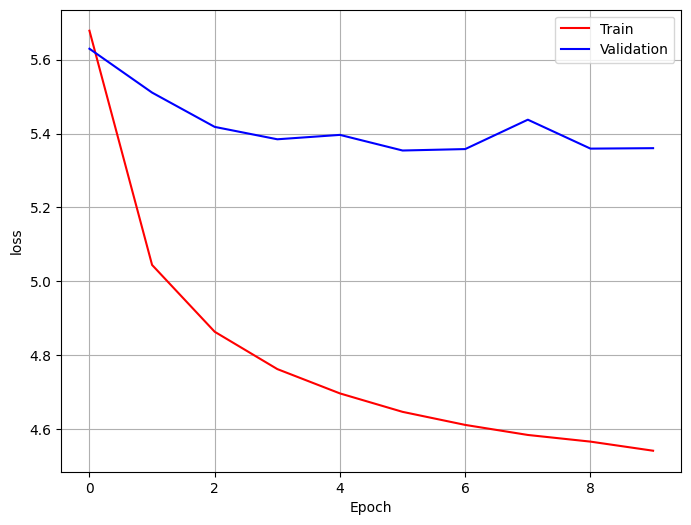

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## Inference

In [ ]:
class Generate():
  def __init__(self, model, max_lenght, num_return_sequences ):
    self.encoder = tiktoken.get_encoding('gpt2')
    self.device = device
    self.model = model
    self.max_lenght= max_lenght
    self.num_return_sequences = num_return_sequences

  def __call__(self, input):

    tokens = self.encoder.encode(input)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(self.num_return_sequences,1)
    input= tokens.to(device)

    torch.manual_seed(10)
    torch.cuda.manual_seed(10)

    while input.size(1)< self.max_lenght:
      with torch.no_grad():
        logits = self.model(input)

        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices  = torch.topk(probs, 5, dim=-1 )
        ix =  torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices,-1,  ix)

        input = torch.cat((input, xcol), dim=1)


    result_tokens = input[0].tolist()
    sentence = self.encoder.decode(result_tokens)
    return sentence


In [ ]:

x = " I am a Programmer."
generator = Generate(model, 32, 1 )
output = generator(x)
print(output)



 I am a Programmer.
O, my liege: I'll be a king's love
To make my brother, my heart to be a grave
